# **UCB W207 Final Project**

## Using Machine Learning to Predict Travel Review Sentiment

Section 3
18 April 2025

Kevin Yi, Kritin Nandish, Thrishna Bhandari, Patrick Abousleiman


# Introduction: Problem Motivation



## Outline for our notebook

* Section 1: We import the data, the source being the Tripadvisor Hotel Review Dataset file with 20K reviews, from the publication: Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic senti- ment: modeling semantic aspects for online reviews. Information Sci- ences 339, 206–223.
* Section 2: We undertake feature engineering and data cleaning. We did xyz....
* Section 3: Simple exploratory data analysis is performed. We found xyx...
* Section 4:  We build several models, starting from the baseline model, logistic regression with one hot encoding, logistic regression with embedding, and multilayer RNN.
* Section 5:  Conclusions from our analysis. 

# Importing libraries 

In [14]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns 
sns.set(style="darkgrid") 
import plotly.graph_objs as plotly  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband
import regex as re


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split


#setting  seed
np.random.seed(100)

# Section 1: Importing data

Our main data source is the US Securities Exchange Commission (SEC), Genderize.io, Yahoo Finance. The data are not processed. 

The features included year, Total (which denotes total compensation: a summation of salary, stock awards, option awards, non-equity incentive compensation and other compensation), Market Cap (stock price * shares outstanding), last and first names, sector (such a technology) and industry (a further classification of sector). 

The original data frame consists of 293,504 rows and 19 features.

In [4]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

#Data Investigation
#We are considering reviews of ratings 3 as negative reviews.
positive_reviews = data[data['Rating'] >= 4]
negative_reviews = data[data['Rating'] <= 3]
print(f"In this dataset of {data.shape[0]} total hotel ratings, there are {positive_reviews.shape[0]} positive ratings, and {negative_reviews.shape[0]} negative hotel ratings.")


In this dataset of 20491 total hotel ratings, there are 15093 positive ratings, and 5398 negative hotel ratings.


# Section 2: Feature engineering

The data required a great deal of cleaning. We noted several issues, including non-sensical values; for example, market capitilization, which is the price of the stock times the shares outstanding was -1 in some rows(impossible) or zero. We filtered the dataframe to remove any irrelevant values.

We also catergorized C-suite job titles and produced bins for salary ranges (which were extremely wide). We binarized male/females.  Lastly, we normalized data for market cap and total compensation. 

After cleaning, the dataframe has 18,081 rows and 24 features. There is a large skew towards men (85% of the rows) and thus we rebalance the data to be a 50/50 split.  After the rebalancing, the training and test dataframe has 2,662 rows each. 




In [16]:
#Data Preprocessing
#checking null values
missing_values = data['Rating'].isnull().any() or data['Review'].isnull().any() # equals False
#There are no missing values in either data column.

In [18]:
#Preprocessing Functions
def preprocessor(text): 
    #Data cleaning
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

def replace_contractions(df, column_name):
    #Replace contractions
    df[column_name] = df[column_name].str.replace(r"ca n't\b", "can not", regex=True)
    df[column_name] = df[column_name].str.replace(r"n't\b", "not", regex=True)
    df[column_name] = df[column_name].str.replace(r"n t\b", "not", regex=True)
    return df

<>:5: SyntaxWarning: invalid escape sequence '\)'
<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:5: SyntaxWarning: invalid escape sequence '\)'
<>:6: SyntaxWarning: invalid escape sequence '\W'
/var/folders/45/ycskhsp10mx8849qvtgg8ch40000gn/T/ipykernel_37668/1337026894.py:5: SyntaxWarning: invalid escape sequence '\)'
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
/var/folders/45/ycskhsp10mx8849qvtgg8ch40000gn/T/ipykernel_37668/1337026894.py:6: SyntaxWarning: invalid escape sequence '\W'
  text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))


In [20]:
#Apply preprocessing
data['Review'] = data['Review'].str.lower()
data['Review'] = data['Review'].apply(preprocessor)

data = replace_contractions(data, 'Review')
data
#We found one row with several typos that we cannot discern the original meaning and will be removing it from the data
data = data.drop(index=2759)

#Redefine negative and positive data subsets with clean data
positive_reviews = data[data['Rating'] >= 4]
negative_reviews = data[data['Rating'] <= 3]

# Section 3: Exploratory Data Analysis


Some findings from EDA:
 
*   US executives of large publicly-traded companies have very high total compensation, and the deviations are extremely large.
*   Very few women executives earning at the top compensation levels.
*  Female CEOs out earn males on average but no female CEOS earning top compensation



### Histograms to analyze data

There is a large spread in compensation, ranging from around 250,000 to 100 million. We noted that most of the compensation is clustered around the lower end of compensation and we analyze by select positions, with CEOs male earning the most and with the largest range in compensation. 

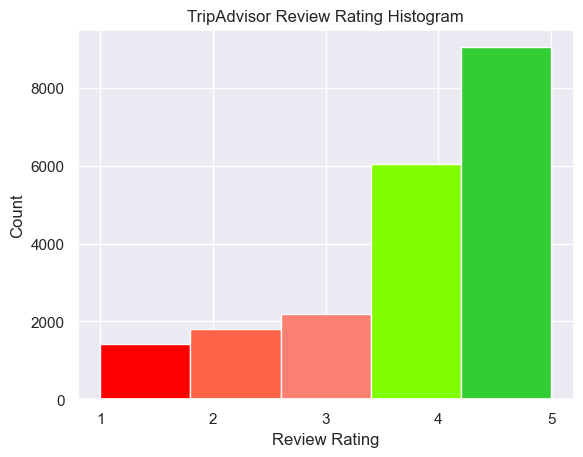

In [22]:
sns.histplot(data['Rating'], bins=5, kde=False) #create histogram of ratings in full dataset

# get the bins to modify color
ax = plt.gca()
patches = ax.patches

# assign colors to bins, shades of red for negative ratings, grey for neutral, shades of green for positive ratings
colors = ['red', 'tomato', 'salmon', 'chartreuse', 'limegreen']
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# set title, labels, and x-axis labels
plt.xticks([1, 2, 3, 4, 5]) 
plt.title("TripAdvisor Review Rating Histogram")
plt.xlabel("Review Rating")
plt.show()

### Word Cloud analyze data


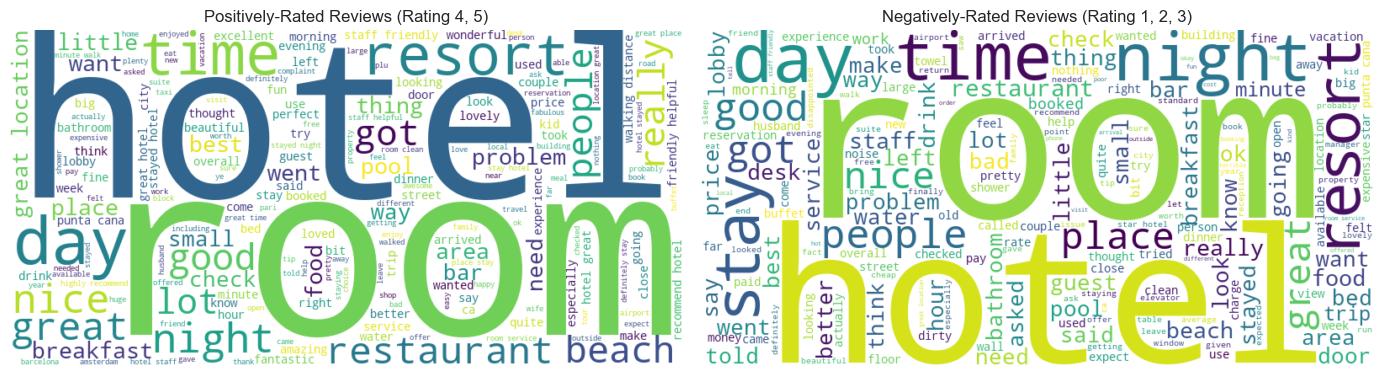

In [26]:
# create a word cloud for negative reviews
negative_review_text = " ".join(negative_reviews['Review'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_review_text)

# create a word cloud for positive reviews
positive_review_text = " ".join(positive_reviews['Review'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_review_text)

# set up the figure with two side-by-side subplots for the positive review and negative review word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Positively-Rated Reviews (Rating 4, 5)") # set title
axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Negatively-Rated Reviews (Rating 1, 2, 3)") # set title

# show the plots
plt.tight_layout()
plt.show()

### Split Data into training, validation, and testing

In [141]:
# shuffle data -- data will be the biased data with either a positive or negative review, we are ignoring neutral data (with Rating 3)
indices = np.arange(0, data.shape[0]) #create indices list
shuffled_indices = np.random.permutation(indices) #shuffle indices
reviews = data['Review'] #create examples
ratings = data['Rating'] #create labels
reviews = reviews[shuffled_indices] #reorder dataset to match shuffled indices
ratings = ratings[shuffled_indices] #reorder dataset to match shuffled indices
    
# create data splits
X_train, X_test, Y_train, Y_test = train_test_split(reviews, ratings, random_state=1234, test_size=.20) #split data into training/testing datasets
X_test, X_val, Y_test, Y_val = train_test_split(X_train, Y_train, random_state=1234, test_size=.50) #split data into testing/validation datasets

### Analyze split data 

In [ ]:
# print shapes
print('Shape of train examples ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of val examples ', X_val.shape)
print('Shape of val labels ', Y_val.shape)

print('Shape of test examples ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

Shape of train examples  (16392,)
Shape of train labels  (16392,)
Shape of val examples  (8196,)
Shape of train labels  (8196,)
Shape of test examples  (8196,)
Shape of test labels  (8196,)


# Section 4: Model building and predictions.

We build a simple model to start, using 1 feature, gender and one layer (model 1).  We then add on other features and multi layers (model2, model3 and model4). In Model5, we use a one-hot encoding to transform the catergorical variable, sector and run a multi-layer 12 feature model. 

## Model 1: One feature, gender
We train a simple model with one feature, gender. We experiment with different learning rates and optimizer and find that learning rate = 0.01 and optimizer Adam has the lowest loss and validation loss and best convergence. Our model predicts that males have higher compensation than females (1.6 million  vs 1.4 million, respectively). 

## Tuning Hyperparameters

We experiment with different optimizers and learning rates.  We find that Adam optimizer plus learning rate of 0.01 has the best convergence of the loss and validation loss.


Model | Optimizer | Learning rate | Loss | Val Loss
-|-|-|-|-|
Model 1: Gender|SGD|0.01|0.046|0.049|
Model 1: Gender|SGD|0.001|0.700|1.344|
Model 1: Gender|SGD|0.0001|1.476|2.801|
Model 1: Gender|Adam|0.01|0.0359|0.0362|
Model 1: Gender|Adam|0.001|1.038|1.934|

## Model 2: 

We used a 

## Model 3: 

We used a 
 


## Model 4: 

We

## Model 5: Multi-layer neutral network, using catergorical data, transformed with one-hot encoding.




# Section 5: Conlusion / Comparing Models. 

